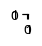

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [2]:
sample = pd.read_csv('../data/mhc1_el_subsample/test_data.csv')

# pseudoseq optim

In [3]:
df = pd.read_csv('../data/mhc1_el_sub10k/sample_no_u.csv')

In [36]:
df200 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv')
df200['len'] = df200['sequence'].apply(len)
df500 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv')
df500['len'] = df500['sequence'].apply(len)

df200['flag'] = df200.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)
df500['flag'] = df500.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)

In [45]:
df200.query('pseudoseq.str.contains("X")')

,sequence,target,HLA,pseudoseq,fold,len,flag
635,IVALILSTK,1.0,HLA-A68:01,YGLIVASTKXXX,0,9,False
975,EENNSFQRL,1.0,HLA-B44:03,PAEEENQRLSPX,0,9,False
1057,KMKEALLSIGK,1.0,HLA-A03:01,MTKKMKIGKXXX,0,11,False
2105,VVNPKYEGK,1.0,HLA-A03:01,VTTVVNEGKXXX,0,9,False
2336,GANSKLTFGKG,0.0,HLA-B44:03,XYTGANGKGITL,0,11,False
...,...,...,...,...,...,...,...
195692,GRLLIQPGPRF,1.0,HLA-B27:01,KPYGRLPRFHXX,4,11,False
195894,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False
196815,DGQKLLFARGTML,0.0,HLA-B51:01,XFSDGQTMLKVD,4,13,False
197104,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False


In [212]:
df200 = df200.query('not flag').rename(columns={'pseudoseq':'context'})
df500 = df500.query('not flag').rename(columns={'pseudoseq':'context'})


In [225]:
from src.data_processing import PSEUDOSEQDICT
df200['pseudoseq'] = df200['HLA'].map(PSEUDOSEQDICT)
df500['pseudoseq'] = df500['HLA'].map(PSEUDOSEQDICT)
print(df500['pseudoseq'].isna().any())
df200.to_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv', index=False)
df500.to_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv', index=False)

False


In [295]:
%ls ../data/mhc1_el_subsample

MHC_pseudo.dat              mhc1_el_500k_subsample.csv
README                      mhc1_el_sub10k/
mhc1_el_200k_subsample.csv  test_data.csv


In [242]:
import glob

for f in glob.glob('../data/mhc1_el_sub10k/*.csv'):
    df = pd.read_csv(f)
    df.rename(columns = {'pseudoseq':'context'}, inplace=True)
    df['pseudoseq'] = df['HLA'].map(PSEUDOSEQDICT)
    assert not df['pseudoseq'].isna().any(), f'{f}wtf man,'
    df.to_csv(f, index=False)

In [293]:
sample = pd.concat([df200.query('HLA=="HLA-A02:01"').sample(100, random_state=13), df200.query('HLA!="HLA-A02:01"').sample(100, random_state=13)])
sample.to_csv('../data/mhc1_el_subsample/test_data.csv', index=False)

# testing on the fly batching

In [281]:
from torch.utils.data import SequentialSampler
from src.datasets import NNAlignDatasetEFSinglePass
dataset = NNAlignDatasetEFSinglePass(sample, 13, 9, 'BL50LO', pad_scale=-20, add_pseudo_sequence=True, indel=True)
loader = dataset.get_dataloader(50, SequentialSampler)
for batch_normal in loader:
    continue

In [284]:
batch_normal[0].shape, batch_normal[1].shape, batch_normal[2].shape, batch_normal[3].shape

(torch.Size([50, 15, 180]),
 torch.Size([50, 15, 1]),
 torch.Size([50, 680]),
 torch.Size([50, 1]))

In [264]:
from src.data_processing import encode
encoding = 'BL50LO'
pad_scale = -20
pseudoseq_tensormap = {k: encode(v, 34, encoding, pad_scale).unsqueeze(0) for k,v in PSEUDOSEQDICT.items()}
hlas = sample['HLA'].values
idx = 0
pseudoseq_tensormap[hlas[idx]]

tensor([[[-2., -1., -2., -3., -3., -1., -2., -3.,  2., -1., -1., -2.,  0.,  4.,
          -3., -2., -2.,  2.,  8., -1.],
         [-3., -3., -4., -5., -2., -4., -3., -4., -1.,  0.,  1., -4.,  0.,  8.,
          -4., -3., -2.,  1.,  4., -1.],
         [ 5., -2., -1., -2., -1., -1., -1.,  0., -2., -1., -2., -1., -1., -3.,
          -1.,  1.,  0., -3., -2.,  0.],
         [-1., -2., -2., -4., -2.,  0., -2., -3., -1.,  2.,  3., -2.,  7.,  0.,
          -3., -2., -1., -1.,  0.,  1.],
         [-2., -1., -2., -3., -3., -1., -2., -3.,  2., -1., -1., -2.,  0.,  4.,
          -3., -2., -2.,  2.,  8., -1.],
         [ 0., -3.,  0., -1., -3., -2., -3.,  8., -2., -4., -4., -2., -3., -4.,
          -2.,  0., -2., -3., -3., -4.],
         [-1.,  0.,  0.,  2., -3.,  2.,  6., -3.,  0., -4., -3.,  1., -2., -3.,
          -1., -1., -1., -3., -2., -3.],
         [-1.,  3.,  0., -1., -3.,  2.,  1., -2.,  0., -3., -3.,  6., -2., -4.,
          -1.,  0., -1., -3., -2., -3.],
         [ 0., -3., -3., -4., -1

In [286]:
import torch
import torch.nn.functional as F
from src.datasets import SuperDataset
from src.data_processing import encode_batch, PFR_calculation, FR_lengths, pep_len_1hot, batch_insertion_deletion, batch_indel_mask, PSEUDOSEQDICT

class TestDataset(SuperDataset):
    """
    CLASS TO USE
    """

    # @profile
    def __init__(self, df: pd.DataFrame, max_len: int, window_size: int, encoding: str = 'onehot',
                 seq_col: str = 'sequence', target_col: str = 'target', pad_scale: float = None, indel: bool = False,
                 burnin_alphabet: str = 'ILVMFYW', feature_cols: list = ['placeholder'],
                 add_pseudo_sequence=False, pseudo_seq_col: str = 'pseudoseq', add_pfr=False, add_fr_len=False,
                 add_pep_len=False, add_z=True):
        # start = dt.now()
        super(TestDataset, self).__init__()
        # Encoding stuff
        if feature_cols is None:
            feature_cols = []
        # Filter out sequences longer than max_len
        df['len'] = df[seq_col].apply(len)
        df = df.query('len<=@max_len')
        # Then, if indel is False, filter out sequences shorter than windowsize (ex: 8mers for WS=9)
        if not indel:
            df = df.query('len>=@window_size')

        matrix_dim = 20
        # query_time = dt.now()
        x = encode_batch(df[seq_col], max_len, encoding, pad_scale)
        y = torch.from_numpy(df[target_col].values).float().view(-1, 1)
        # encode_time = dt.now()
        # Creating the mask to allow selection of kmers without padding
        len_mask = torch.from_numpy(df['len'].values)
        x_mask = len_mask - window_size
        range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
        # Mask for Kmers + padding
        x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)
        # Expand the kmers windows for base sequence without indels
        x = x.unfold(1, window_size, 1).transpose(2, 3) \
             .reshape(len(x), max_len - window_size + 1, window_size, matrix_dim)
        # Creating indels window and mask 
        if indel:
            x_indel = batch_insertion_deletion(df[seq_col], max_len, encoding, pad_scale, window_size)
            # remove padding from indel windows
            x_indel = x_indel[:,:,:window_size, :]
            indel_mask = batch_indel_mask(len_mask, window_size)
            x = torch.cat([x, x_indel], dim=1)
            x_mask = torch.cat([x_mask, indel_mask], dim=1)
        
        # Creating another mask for the burn-in period+bool flag switch
        self.burn_in_mask = _get_burnin_mask_batch(df[seq_col].values, max_len, window_size, burnin_alphabet).unsqueeze(
            -1)
        self.burn_in_flag = False

        # Expand and unfold the sub kmers and the target to match the shape ; contiguous to allow for view operations
        self.x_tensor = x.flatten(2, 3).contiguous()
        self.x_mask = x_mask
        
        self.pseudoseq_tensormap = {k: encode(v, 34, encoding, pad_scale).unsqueeze(0).flatten(start_dim=1) for k,v in PSEUDOSEQDICT.items()}
        # kmer_time = dt.now()
        self.y = y.contiguous()
        self.x_features = torch.empty((len(x),))
        # Add extra features
        if len(feature_cols) > 0:
            # TODO: When you add more features you need to concatenate to x_pseudosequence and save it to self.x_features
            # these are NUMERICAL FEATURES like %Rank, expression, etc. of shape (N, len(feature_cols))
            # x_features = torch.from_numpy(df[feature_cols].values).float()

            self.extra_features_flag = True
        else:
            self.extra_features_flag = False

        #  TODO dictmap for 9mer look-up and see if how many duplicated and can we save memory
        #
        if add_pseudo_sequence:
            self.hla_tag = df['HLA'].values
            self.extra_features_flag = True
            # ps_time = dt.now()
        if add_pfr:
            x_pfr = PFR_calculation(df[seq_col], self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_pfr], dim=2)
            # pfr_time = dt.now()
        if add_fr_len:
            x_fr_len = FR_lengths(self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_fr_len], dim=2)
            # pfr_len_time = dt.now()
        if add_pep_len:
            x_pep_len = pep_len_1hot(df[seq_col], max_len, window_size, min_length=13, max_length=21)
            self.x_tensor = torch.cat([self.x_tensor, x_pep_len], dim=2)
            # peplen_time = dt.now()

        # Saving df in case it's needed
        self.df = df
        self.len = len(x)
        self.max_len = max_len
        self.seq_col = seq_col
        self.window_size = window_size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        """ Returns the appropriate input tensors (X, ..., y) depending on the bool flags
        A bit convoluted return, but basically 4 conditions:
            1. No burn-in, no extra features --> returns the normal x_tensor, kmers mask, target
            2. Burn-in, no extra features --> returns the normal x_tensor, burn-in mask, target
            3. No Burn-in, + extra features --> returns the normal x_tensor, kmers mask, x_features, target
            4. Burn-in, + extra features --> returns the normal x_tensor, burn-in mask, x_features, target
        :param idx:
        :return:
        """
        if self.burn_in_flag:
            if self.extra_features_flag:
                x_pseudoseq = self.pseudoseq_tensormap[self.hlas[idx]]
                return self.x_tensor[idx], self.burn_in_mask[idx], x_pseudoseq, self.y[idx]
            else:
                # 2
                return self.x_tensor[idx], self.burn_in_mask[idx], self.y[idx]
        else:
            if self.extra_features_flag:
                # 3
                return self.x_tensor[idx], self.x_mask[idx], x_pseudoseq, self.y[idx]
            else:
                # 1
                return self.x_tensor[idx], self.x_mask[idx], self.y[idx]

    def burn_in(self, flag):
        self.burn_in_flag = flag

def _get_burnin_mask_batch(sequences, max_len, motif_len, alphabet='ILVMFYW'):
    return torch.stack([_get_burnin_mask(x, max_len, motif_len, alphabet) for x in sequences])


def _get_burnin_mask(seq, max_len, motif_len, alphabet='ILVMFYW'):
    mask = torch.tensor([x in alphabet for i, x in enumerate(seq) if i < len(seq) - motif_len + 1]).float()
    return F.pad(mask, (0, (max_len - motif_len + 1) - len(mask)), 'constant', 0)


In [287]:
testdataset = TestDataset(sample, 13, 9, 'BL50LO', pad_scale=-20, add_pseudo_sequence=True, indel=True)
testloader = dataset.get_dataloader(50, SequentialSampler)
for batch in testloader:
    continue

In [289]:
(batch[0]==batch_normal[0]).all()

tensor(True)

In [290]:
(batch[2]==batch_normal[2]).all()

tensor(True)

In [288]:
batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape

(torch.Size([50, 15, 180]),
 torch.Size([50, 15, 1]),
 torch.Size([50, 680]),
 torch.Size([50, 1]))

# what the init code

In [303]:
from src.datasets import NNAlignDatasetEFSinglePass, PseudoOTFDataset
from src.models import NNAlignEFSinglePass
from src.utils import get_class_initcode_keys

In [305]:
args = {'max_len':13}
get_class_initcode_keys(PseudoOTFDataset, args)

['max_len']

In [312]:
# stupid init code name changes if we profile it ; Need a UglyWorkAround class to get the same init

[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-pa

In [304]:
PseudoOTFDataset.__init__.__code__.co_varnames

('self',
 'df',
 'max_len',
 'window_size',
 'encoding',
 'seq_col',
 'target_col',
 'pad_scale',
 'indel',
 'burnin_alphabet',
 'feature_cols',
 'add_pseudo_sequence',
 'pseudo_seq_col',
 'add_pfr',
 'add_fr_len',
 'add_pep_len',
 'add_z',
 'matrix_dim',
 'x',
 'y',
 'len_mask',
 'x_mask',
 'range_tensor',
 'x_indel',
 'indel_mask',
 'x_pfr',
 'x_fr_len',
 'x_pep_len')

In [306]:
NNAlignDatasetEFSinglePass.__init__.__code__.co_varnames

('args', 'kwargs', 'prof', 'val')

In [311]:
NNAlignDatasetEFSinglePass.__init__.__code__.

b'\x95\x03\x97\x00\x02\x00\x89\x05\xa6\x00\x00\x00\xab\x00\x00\x00\x00\x00\x00\x00\x00\x00}\x02\x02\x00\x02\x00|\x02\x89\x04\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00|\x00i\x00|\x01\xa4\x01\x8e\x01}\x03\x02\x00\x89\x06|\x02\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00|\x03S\x00'

In [301]:
NNAlignEFSinglePass.__init__.__code__.co_varnames

('self',
 'n_hidden',
 'n_hidden_2',
 'window_size',
 'activation',
 'extrafeat_dim',
 'batchnorm',
 'dropout',
 'standardize',
 'add_hidden_layer')

# burn_in mask need to match indel mask

In [368]:
''.join(AA_KEYS)

'ARNDCQEGHILKMFPSTWYV'

In [313]:

def _get_burnin_mask_batch(sequences, max_len, motif_len, alphabet='ILVMFYW'):
    return torch.stack([_get_burnin_mask(x, max_len, motif_len, alphabet) for x in sequences])


def _get_burnin_mask(seq, max_len, motif_len, alphabet='ILVMFYW'):
    mask = torch.tensor([x in alphabet for i, x in enumerate(seq) if i < len(seq) - motif_len + 1]).float()
    return F.pad(mask, (0, (max_len - motif_len + 1) - len(mask)), 'constant', 0)

In [315]:
_get_burnin_mask_batch(sample['sequence'].head(15), 13, 9)

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [317]:
sample['sequence'].head(15).iloc[0]

'ELEMIKKKHLV'

In [332]:
sample['sequence'].head(15).iloc[1]

'QMEARQKECGA'

In [331]:
sample['sequence'].head(15).iloc[4]

'RQLASEGLPAL'

In [333]:
sample['sequence'].head(15).iloc[-3]

'FLQLMIDSQ'

In [316]:
sample['sequence'].head(15).iloc[-1]

'ADNIYIFLEL'

In [343]:
seq='VELEMIKKKHL'
indel_windows = get_indel_windows(seq, 9)
indel_burnin_mask = torch.tensor([x[0] in alphabet for x in indel_windows]).float()
print(seq, len(seq))
print(indel_windows)
print(indel_burnin_mask, indel_burnin_mask.shape)

VELEMIKKKHL 11
['LEMIKKKHL', 'VEMIKKKHL', 'VEMIKKKHL', 'VELIKKKHL', 'VELEKKKHL', 'VELEMKKHL', 'VELEMIKHL', 'VELEMIKHL', 'VELEMIKKL', 'VELEMIKKK']
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) torch.Size([10])


In [345]:
def _get_indel_burnin_mask(seq, window_size, alphabet='ILVMFYW'):
    indel_windows = get_indel_windows(seq, window_size)
    return torch.tensor([x[0] in alphabet for x in indel_windows]).float()

def _get_indel_burnin_mask_batch(sequences, window_size, alphabet='ILVMFYW'):
    return torch.stack([_get_indel_burnin_mask(x, window_size, alphabet) for x in sequences])


In [355]:
indel_burnin_mask = _get_indel_burnin_mask_batch(sample['sequence'], 9).unsqueeze(-1)

In [356]:
indel_burnin_mask.shape

torch.Size([200, 10, 1])

In [357]:
dataset.burn_in_mask.shape

torch.Size([200, 5, 1])

In [364]:
torch.cat([dataset.burn_in_mask, indel_burnin_mask], dim=1).shape

torch.Size([200, 15, 1])

# Optim / vectorize Carlos' code

## Parallelize encode_batch

In [3]:
from src.data_processing import encode

def encode_batch(sequences, max_len=None, encoding='onehot', pad_scale=None):
    """
    Encode multiple sequences at once.
    """
    if max_len is None:
        max_len = max([len(x) for x in sequences])
    # Contiguous to allow for .view operation
    return torch.stack([encode(seq, max_len, encoding, pad_scale) for seq in sequences]).contiguous()



In [4]:
sample_200 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv')
sample_500 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv')

In [766]:
from joblib import Parallel, delayed
from functools import partial

def encode_batch_parallel(sequences, max_len, encoding, pad_scale, n_jobs=1):
    if max_len is None:
        max_len = max([len(x) for x in sequences])

    assert n_jobs!=0, "n_jobs can't be 0! should be either -1 or >1, or == 1 to run a single process"
    if n_jobs!=1:
        wrapper = partial(encode, max_len=max_len, encoding=encoding, pad_scale=pad_scale)
        return torch.stack(Parallel(n_jobs=n_jobs)(delayed(wrapper)(seq) for seq in sequences)).contiguous()
    else:
        return torch.stack([encode(seq, max_len, encoding, pad_scale) for seq in sequences]).contiguous()

from multiprocessing import Pool

def encode_batch_parallel2(sequences, max_len, encoding, pad_scale, n_jobs=1):
    if max_len is None:
        max_len = max(len(x) for x in sequences)

    if n_jobs != 1:
        wrapper = partial(encode, max_len=max_len, encoding=encoding, pad_scale=pad_scale)
        with Pool(processes=n_jobs) as pool:
            return torch.stack(pool.map(wrapper, sequences)).contiguous()
    else:
        return torch.stack([encode(seq, max_len, encoding, pad_scale) for seq in sequences]).contiguous()


In [767]:
from time import perf_counter as pc
max_len = 13
encoding = 'BL50LO'
pad_scale = -20
# 200k 
start_200 = pc()
encode_batch(sample_200['sequence'].values, max_len, encoding, pad_scale)
end_200 = pc()
print(end_200-start_200)
# 500k 
start_500 = pc()
encode_batch(sample_500['sequence'].values, max_len, encoding, pad_scale)
end_500 = pc()
print(end_500-start_500)

1.755262833001325
5.617532249998476


In [768]:
# 200k 
start_200 = pc()
encode_batch_parallel(sample_200['sequence'].values, max_len, encoding, pad_scale, n_jobs=5)
end_200 = pc()
print(end_200-start_200)
# 500k 
start_500 = pc()
encode_batch_parallel(sample_500['sequence'].values, max_len, encoding, pad_scale, n_jobs=5)
end_500 = pc()
print(end_500-start_500)

8.39354325000022
18.800689040996076


In [21]:
# 200k 
start_200 = pc()
encode_batch_parallel2(sample_200['sequence'].values, max_len, encoding, pad_scale, n_jobs=5)
end_200 = pc()
print(end_200-start_200)
# 500k 
start_500 = pc()
encode_batch_parallel2(sample_500['sequence'].values, max_len, encoding, pad_scale, n_jobs=5)
end_500 = pc()
print(end_500-start_500)

15.87753145900001
38.10106829100005


## vectorize PFR

In [5]:
def get_xxs(df, max_len, encoding, pad_scale, window_size=9):
    x = encode_batch(df['sequence'], max_len, encoding, pad_scale)
    # Creating the mask to allow selection of kmers without padding
    len_mask = torch.from_numpy(df['len'].values)
    x_mask = len_mask - window_size
    range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
    # Mask for Kmers + padding
    x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)
    # Expand the kmers windows for base sequence without indels
    x = x.unfold(1, window_size, 1).transpose(2, 3) \
        .reshape(len(x), max_len - window_size + 1, window_size, 20)
    return x, x_mask

x_200, mask_200 = get_xxs(sample_200, max_len, encoding, pad_scale, window_size=9)
x_500, mask_500 = get_xxs(sample_500, max_len, encoding, pad_scale, window_size=9)

### step by step deconstruct / redo pfr

In [40]:
import torch

def PFR_calculation_vect(df_seq, all_xmask, max_len, window_size=9):
    data = encode_batch(df_seq, max_len, 'BL62FREQ', None)  # Assuming encode_batch is a function to process df_seq
    batch_size, seq_len, aa_dim = data.shape

    # Previous PFR mask definition
    PFR_mask_before = 3 * torch.ones((1, seq_len - window_size + 1, 1))
    PFR_mask_before[:, :3, 0] = torch.tensor([0, 1, 2], dtype=torch.float32)  # First three elements to 1 and 2

    # After PFR mask definition (according to their x_mask)
    PFR_mask_after = all_xmask * 3

    # Modification of the previous values before 0 (only if zero exists)
    zero_indices = torch.where(PFR_mask_after == 0)
    zero_index = zero_indices[0][0] if zero_indices[0].numel() > 0 else -1

    if zero_index != -1:
        zero_index = zero_index.item()
        PFR_mask_after[zero_index - 3:zero_index] = torch.tensor([2, 1, 0])[:zero_index]

    # Create indices for the sliding window
    indices = torch.arange(0, seq_len - window_size + 1).view(1, -1) + torch.arange(0, window_size).view(-1, 1)

    # Expand dimensions for broadcasting
    indices = indices.unsqueeze(0).unsqueeze(-1)

    # Extract WS-mers from the input sequence
    windows = data[:, indices]

    # Compute PFR tensors
    prev_pfr = torch.sum(windows[:, :, :int(PFR_mask_before[0])], dim=2, keepdim=True) / 3
    after_pfr = torch.sum(windows[:, :, window_size:int(window_size + PFR_mask_after)], dim=2, keepdim=True) / 3

    # Concatenate PFR tensors along the second axis
    all_pfr = torch.cat((prev_pfr, after_pfr), dim=2)

    return all_pfr.flatten(start_dim=2)


In [56]:
x_200, mask_200 = get_xxs(sample_200, max_len, encoding, pad_scale, window_size=9)
x_500, mask_500 = get_xxs(sample_500, max_len, encoding, pad_scale, window_size=9)

In [577]:
max_len=13
window_size=5

sample = sample_200.groupby('len', group_keys=False).apply(lambda x: x.sample(1, random_state=13))
data = encode_batch(sample['sequence'], max_len, 'BL62FREQ', None)
batch_size, seq_len, aa_dim = data.shape
_, mask_10  = get_xxs(sample, max_len, encoding, pad_scale, window_size)
pfr10 = PFR_calculation(sample['sequence'].values, mask_10, max_len, window_size=9)

In [578]:
data.shape, mask_10.shape, pfr10.shape

(torch.Size([6, 13, 20]), torch.Size([6, 9, 1]), torch.Size([6, 5, 40]))

In [149]:
j = 5
print('///////')
print(sample.iloc[j][['sequence', 'len']].values)
print('\n##############\n')
seq = data[j, :]
PFR_mask_before = 3 * torch.ones((max_len - window_size + 1, 1))
PFR_mask_before[:3, 0] = torch.tensor([0, 1, 2], dtype=torch.float32)  # First three elements to 1 and 2
# After PFR mask definition (according to their x_mask)
PFR_mask_after = torch.clone(mask_10[j]) * 3
print('PFR BEFORE\n',PFR_mask_before, '\nPFR AFTER\n', PFR_mask_after)
zero_indices = torch.where(PFR_mask_after == 0)[0]
print(zero_indices, zero_indices.numel())
print('\n##############\n')
if zero_indices.numel() > 0:  # Check if there are any zero indices
    zero_index = zero_indices[0]  # Get the first zero index
    PFR_mask_after[zero_index - 3] = 2 if zero_index >= 3 else PFR_mask_after[zero_index - 3]
    PFR_mask_after[zero_index - 2] = 1 if zero_index >= 2 else PFR_mask_after[zero_index - 2]
    PFR_mask_after[zero_index - 1] = 0 if zero_index >= 1 else PFR_mask_after[zero_index - 1]
print(PFR_mask_after)

///////
['EKIIGAGKPWHKN' 13]

##############

PFR BEFORE
 tensor([[0.],
        [1.],
        [2.],
        [3.],
        [3.]]) 
PFR AFTER
 tensor([[3.],
        [3.],
        [3.],
        [3.],
        [3.]])
tensor([], dtype=torch.int64) 0

##############

tensor([[3.],
        [3.],
        [3.],
        [3.],
        [3.]])


In [192]:
PFR_mask_after.shape, PFR_mask_before.shape

(torch.Size([6, 5, 1]), torch.Size([6, 5, 1]))

In [259]:
sequences = sample['sequence'].values
random_seqs = sample_200.sample(100)

max_len = 13
window_size = 9
display(sample)

,sequence,target,HLA,context,fold,len,flag,pseudoseq
30867,RVIPRWNV,0.0,HLA-C06:02,QRGRVIWNVSHL,0,8,False,YDSGYREKYRQADVNKLYLWYDSYTWAEWAYTWY
116342,EALEDPSPE,0.0,HLA-A31:01,LTMEALSPELME,2,9,False,YTAMYQENVAHIDVDTLYIMYQDYTWAVLAYTWY
110070,MTFSGLNRGF,0.0,HLA-B57:01,RLMMTFRGFAYA,2,10,False,YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY
161107,NLLSSRQVMNT,0.0,HLA-C17:01,VVLNLLMNTHFN,4,11,False,YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY
57799,MWKAQGDQGLER,0.0,HLA-C06:02,LWLMWKLERRID,1,12,False,YDSGYREKYRQADVNKLYLWYDSYTWAEWAYTWY
198561,EKIIGAGKPWHKN,0.0,HLA-C08:02,YAAEKIHKNCFR,4,13,False,YYAGYREKYRQTDVSNLYLRYNFYTWAERAYTWY


In [475]:
PFR_mask_before, PFR_mask_after

(tensor([[0, 1, 2, 3, 3, 3, 3, 3, 3],
         [0, 1, 2, 3, 3, 3, 3, 3, 3],
         [0, 1, 2, 3, 3, 3, 3, 3, 3],
         [0, 1, 2, 3, 3, 3, 3, 3, 3],
         [0, 1, 2, 3, 3, 3, 3, 3, 3],
         [0, 1, 2, 3, 3, 3, 3, 3, 3]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 1, 1, 1, 1, 0, 0, 0],
         [3, 2, 2, 2, 2, 2, 1, 0, 0],
         [3, 3, 3, 3, 3, 3, 2, 1, 0]]))

In [294]:
pfrs = PFR_calculation(sequences, mask_10, 13, 9)

In [296]:
pfrs.shape

torch.Size([6, 5, 40])

### masking

In [798]:
def pfr_mask_after_single(l, max_len, window_size):
    n_windows = max_len-window_size+1
    n_3 = l - window_size - 2
    n_2 = 1 if n_3>=0 else max(n_3+1, -1)
    n_1 = 1 if n_2>=0 else max(n_2+1, -1)
    out = torch.cat([torch.full((max(n_3,0),),3), torch.full((max(n_2,0),), 2), torch.full((max(n_1,0),), 1)])
    return F.pad(out, (0, n_windows-len(out)), value=0)

def batch_pfr_mask_indices(lens, max_len, window_size):
    mask = torch.stack([pfr_mask_after_single(l, max_len, window_size) for l in lens])
    indices = torch.stack([(torch.arange(0, n_windows)+window_size-1).repeat(len(mask),1).T, (torch.arange(0, n_windows)+window_size-1+mask).T]).T
    return mask, indices

In [814]:
start_500k_mask = pc()
mask2, indices2 = batch_pfr_mask_indices(torch.randint(low=8,high=14, size=(500000,)), max_len, window_size)
end_500k_mask = pc()
print(end_500k_mask - start_500k_mask)

11.96152345900191


In [725]:
window_size = 9
max_len = 13 


n_windows = max_len - window_size + 1
n_3 = len_tensor - window_size - 2
n_2 = torch.where(n_3 >= 0, 1, torch.tensor([-1]))
n_1 = torch.where(n_2 >= 0, 1, torch.tensor([-1]))
max_n_3 = torch.max(torch.tensor([0]), n_3)
max_n_2 = torch.max(torch.tensor([0]), n_2)
max_n_1 = torch.max(torch.tensor([0]), n_1)

out = torch.zeros((len_tensor.shape[0], n_windows))

In [748]:
print(n_3, n_2, n_1)
print(max_n_3, max_n_2, max_n_1)
idx_3 = torch.where(n_3>0, max_n_3, -1)
idx_2 = torch.where(n_2>0, idx_3 + 1, -1)
idx_1 = torch.where(n_1>0, idx_2 + 1, -1)
print(idx_3, idx_2, idx_1)

tensor([-3, -2, -1,  0,  1,  2]) tensor([-1, -1, -1,  1,  1,  1]) tensor([-1, -1, -1,  1,  1,  1])
tensor([0, 0, 0, 0, 1, 2]) tensor([0, 0, 0, 1, 1, 1]) tensor([0, 0, 0, 1, 1, 1])
tensor([-1, -1, -1, -1,  1,  2]) tensor([-1, -1, -1,  0,  2,  3]) tensor([-1, -1, -1,  1,  3,  4])


In [815]:
indices2.shape

torch.Size([500000, 9, 2])

In [779]:
max_len, window_size = 13, 5
n_windows = max_len - window_size + 1 
# vectorizing ; 
data = encode_batch(sequences, max_len, 'BL62FREQ', None) # shape (N, 13, 20)
len_tensor = torch.tensor([len(x) for x in sequences])
PFR_mask_before = torch.full((len(data), max_len-window_size+1), 3)
PFR_mask_before[:, :3] = torch.tensor([0,1,2], dtype=torch.float32)
# Mask before is ALWAYS the same.
PFR_mask_after = pfr_mask_after_batch(len_tensor, max_len, window_size)
print(PFR_mask_before,'\n', PFR_mask_after,'\n')

j = 2
n_windows = max_len-window_size+1
seq = data[j]
mask_before = PFR_mask_before[j]
mask_after = PFR_mask_after[j]
# use these indices to slice somehow 
# SCRATCHPAD
after_indices = torch.stack([torch.arange(0, n_windows)+window_size-1, torch.arange(0, n_windows)+window_size-1+mask_after]).T
before_indices = torch.stack([torch.arange(0, n_windows)-mask_before, torch.arange(0, n_windows)]).T
print(before_indices,'\n', after_indices )
# indices should be used as a [start:end] slicing ? 

tensor([[0, 1, 2, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 3, 3, 3, 3, 3]]) 
 (tensor([[3, 2, 1, 0, 0, 0, 0, 0, 0],
        [3, 3, 2, 1, 0, 0, 0, 0, 0],
        [3, 3, 3, 2, 1, 0, 0, 0, 0],
        [3, 3, 3, 3, 2, 1, 0, 0, 0],
        [3, 3, 3, 3, 3, 2, 1, 0, 0],
        [3, 3, 3, 3, 3, 3, 2, 1, 0]]), tensor([[[ 4,  7],
         [ 5,  7],
         [ 6,  7],
         [ 7,  7],
         [ 8,  8],
         [ 9,  9],
         [10, 10],
         [11, 11],
         [12, 12]],

        [[ 4,  7],
         [ 5,  8],
         [ 6,  8],
         [ 7,  8],
         [ 8,  8],
         [ 9,  9],
         [10, 10],
         [11, 11],
         [12, 12]],

        [[ 4,  7],
         [ 5,  8],
         [ 6,  9],
         [ 7,  9],
         [ 8,  9],
         [ 9,  9],
         [10, 10],
         [11, 11],
         [12, 12]],

        [[ 4,  7],
         [ 5

IndexError: tuple index out of range

### Slicing gathering?

In [851]:
from src.data_processing import FR_lengths

FR_lengths(mask_10, 13, 5)

tensor([[[0.0000, 1.0000, 0.7500, 0.2500],
         [0.5000, 0.5000, 0.6667, 0.3333],
         [0.6667, 0.3333, 0.5000, 0.5000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000],
         [0.8333, 0.1667, 0.0000, 1.0000],
         [0.8571, 0.1429, 0.0000, 1.0000],
         [0.8750, 0.1250, 0.0000, 1.0000],
         [0.8889, 0.1111, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.8000, 0.2000],
         [0.5000, 0.5000, 0.7500, 0.2500],
         [0.6667, 0.3333, 0.6667, 0.3333],
         [0.7500, 0.2500, 0.5000, 0.5000],
         [0.8000, 0.2000, 0.0000, 1.0000],
         [0.8333, 0.1667, 0.0000, 1.0000],
         [0.8571, 0.1429, 0.0000, 1.0000],
         [0.8750, 0.1250, 0.0000, 1.0000],
         [0.8889, 0.1111, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.8333, 0.1667],
         [0.5000, 0.5000, 0.8000, 0.2000],
         [0.6667, 0.3333, 0.7500, 0.2500],
         [0.7500, 0.2500, 0.6667, 0.3333],
         [0.8000, 0.2000, 0.5000, 0.5000],
       

In [915]:
get_pfr_indices_after(10, 13, 9)

tensor([1, 0, 0, 0, 0])

In [929]:
max_len=13
window_size=5
n_windows=max_len-window_size+1
mask = pfr_mask_after_single(13, 13, 5)
index=torch.stack([torch.arange(0, n_windows)+window_size, torch.arange(0, n_windows)+window_size+mask]).T
mask_from_index(torch.stack([index,index]))

tensor([[[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=torch.int32)

In [983]:
def get_pfr_indices_after(l, max_len, window_size):
    n_windows = max_len-window_size+1
    n_3 = l - window_size - 2
    n_2 = 1 if n_3>=0 else max(n_3+1, -1)
    n_1 = 1 if n_2>=0 else max(n_2+1, -1)
    mask = torch.cat([torch.full((max(n_3,0),),3), torch.full((max(n_2,0),), 2), torch.full((max(n_1,0),), 1)])
    mask = F.pad(mask, (0, n_windows-len(mask)), value=0)
    return torch.stack([torch.arange(0, n_windows)+window_size, torch.arange(0, n_windows)+window_size+mask]).T

def get_pfr_indices_after_batch(lengths, max_len, window_size):
    return torch.stack([get_pfr_indices_after(l, max_len, window_size) for l in lengths])
    
def mask_from_index(index_tensor):
    N, S, _ = index_tensor.shape  # Batch size, number of sequences, 2 (for start and end indices)

    # Create a range tensor of shape [1, 1, max_len] for broadcasting
    range_tensor = torch.arange(max_len).unsqueeze(0).unsqueeze(0)
    
    # Expand before_indices for start and end to match the shape for broadcasting
    start_indices = index_tensor[:,:,0].unsqueeze(2)  # Shape: [N, S, 1]
    end_indices = index_tensor[:,:,1].unsqueeze(2)  # Shape: [N, S, 1], +1 to include the end index in the range
    
    # Create the binary mask
    mask = (range_tensor >= start_indices) & (range_tensor < end_indices)  # Shape: [N, S, max_len]
    
    return mask.int()

    
max_len, window_size = 13, 9

# What the fuck at no point do I ever need the mask if I use index
n_windows = max_len - window_size + 1 
# vectorizing ; 
data = encode_batch(sequences, max_len, 'BL62FREQ', None) # shape (N, 13, 20)
len_tensor = torch.tensor([len(x) for x in sequences])
mask_before = torch.full((max_len-window_size+1, ), 3)
mask_before[:3] = torch.tensor([0,1,2], dtype=torch.float32)
# Mask before is ALWAYS the same.
before_indices = torch.stack([torch.arange(0, n_windows)-mask_before, torch.arange(0, n_windows)]).T.repeat(len(data), 1, 1)
after_indices = get_pfr_indices_after_batch(len_tensor, max_len, window_size)
before_mask = mask_from_index(before_indices).unsqueeze(-1).repeat(1,1,1,20)
after_mask = mask_from_index(after_indices).unsqueeze(-1).repeat(1,1,1,20)
# Create the repeat vector to mask and compute the results
repeats = data.unsqueeze(1).repeat(1, n_windows, 1, 1)
(repeats[0, 0, 0, :] == repeats[0, 2, 0, :]).all()

tensor(True)

In [981]:
repeats.shape, after_mask.shape, before_mask.shape

(torch.Size([6, 9, 13, 20]),
 torch.Size([6, 9, 13, 20]),
 torch.Size([6, 9, 13, 20]))

In [986]:
a=(repeats * after_mask).mean(dim=2)
b=(repeats * before_mask).mean(dim=2)

torch.cat([a,b], dim=2).shape

torch.Size([6, 5, 40])

In [ ]:
def get_pfr_values(sequences, max_len, window_size):
    # Get the true lengths of each sequence to create the masks
    len_tensor = torch.tensor([len(x) for x in sequences])
    n_windows = max_len-window_size+1
    # Get the data vector to repeat and mask to compute PFR
    blosum_freq = encode_batch(sequences, max_len, 'BL62FREQ', None)
    # Get the repeated blosum_freq vector (creating N_windows copies along dim=1)
    repeats = blosum_freq.unsqueeze(1).repeat(1, n_windows, 1, 1)
    # The before mask is the same no matter the length so create it and just repeat it to get the indices
    before_mask = torch.full((n_windows, ), 3)
    before_mask[:3] = torch.tensor([0,1,2], dtype=torch.float32)
    before_indices = torch.stack([torch.arange(0, n_windows)-mask_before, torch.arange(0, n_windows)]).T.repeat(len(data), 1, 1)
    # Use my custom function and length tensor to create the after_indices
    after_indices = get_pfr_indices_after_batch(len_tensor, max_len, window_size)
    # Create the mask of shape (N, n_windows, max_len, 20) to use on the repeated freq_data and broadcast it 20 times along amino acid dimension
    before_mask = mask_from_index(before_indices).unsqueeze(-1).repeat(1,1,1,20)
    after_mask = mask_from_index(after_indices).unsqueeze(-1).repeat(1,1,1,20)
    # Take dim=2 because that's the sequence length dimension 
    pfr_before = (repeats*before_mask).mean(dim=2)
    pfr_after = (repeats*after_mask).mean(dim=2)
    return torch.cat([pfr_before, pfr_after], dim=2)

### final comparison

In [10]:
def get_pfr_indices_after(l, max_len, window_size):
    n_windows = max_len-window_size+1
    n_3 = l - window_size - 2
    n_2 = 1 if n_3>=0 else max(n_3+1, -1)
    n_1 = 1 if n_2>=0 else max(n_2+1, -1)
    mask = torch.cat([torch.full((max(n_3,0),),3), torch.full((max(n_2,0),), 2), torch.full((max(n_1,0),), 1)])
    mask = F.pad(mask, (0, n_windows-len(mask)), value=0)
    return torch.stack([torch.arange(0, n_windows)+window_size, torch.arange(0, n_windows)+window_size+mask]).T

def get_pfr_indices_after_batch(lengths, max_len, window_size):
    return torch.stack([get_pfr_indices_after(l, max_len, window_size) for l in lengths])
    
def mask_from_index(index_tensor):
    N, S, _ = index_tensor.shape  # Batch size, number of sequences, 2 (for start and end indices)

    # Create a range tensor of shape [1, 1, max_len] for broadcasting
    range_tensor = torch.arange(max_len).unsqueeze(0).unsqueeze(0)
    
    # Expand before_indices for start and end to match the shape for broadcasting
    start_indices = index_tensor[:,:,0].unsqueeze(2)  # Shape: [N, S, 1]
    end_indices = index_tensor[:,:,1].unsqueeze(2)  # Shape: [N, S, 1], +1 to include the end index in the range
    
    # Create the binary mask
    mask = (range_tensor >= start_indices) & (range_tensor < end_indices)  # Shape: [N, S, max_len]
    
    return mask.int()

def get_pfr_values(sequences, max_len, window_size):
    # Get the true lengths of each sequence to create the masks
    len_tensor = torch.tensor([len(x) for x in sequences])
    n_windows = max_len-window_size+1
    # Get the data vector to repeat and mask to compute PFR
    blosum_freq = encode_batch(sequences, max_len, 'BL62FREQ', None)
    # Get the repeated blosum_freq vector (creating N_windows copies along dim=1)
    repeats = blosum_freq.unsqueeze(1).repeat(1, n_windows, 1, 1)
    # The before mask is the same no matter the length so create it and just repeat it to get the indices
    before_mask = torch.full((n_windows, ), 3)
    before_mask[:3] = torch.tensor([0,1,2], dtype=torch.float32)
    before_indices = torch.stack([torch.arange(0, n_windows)-before_mask, torch.arange(0, n_windows)]).T.repeat(len(sequences), 1, 1)
    # Use my custom function and length tensor to create the after_indices
    after_indices = get_pfr_indices_after_batch(len_tensor, max_len, window_size)
    # Create the mask of shape (N, n_windows, max_len, 20) to use on the repeated freq_data and broadcast it 20 times along amino acid dimension
    before_mask = mask_from_index(before_indices).unsqueeze(-1).repeat(1,1,1,20)
    after_mask = mask_from_index(after_indices).unsqueeze(-1).repeat(1,1,1,20)
    # Take dim=2 because that's the sequence length dimension 
    pfr_before = (repeats*before_mask).mean(dim=2)
    pfr_after = (repeats*after_mask).mean(dim=2)
    return torch.cat([pfr_before, pfr_after], dim=2)

In [12]:
window_size=9
max_len=13

get_pfr_values(sample.sample(5)['sequence'].values, max_len, window_size).shape

torch.Size([5, 5, 40])

In [19]:
len_sample = sample.groupby('len', group_keys=False).apply(lambda x: x.sample(1))
pfrs = get_pfr_values(len_sample['sequence'].values, max_len, window_size)

In [29]:
# testing time
from time import perf_counter as pc
from src.data_processing import PFR_calculation
def get_xxs(df, max_len, encoding, pad_scale, window_size=9):
    x = encode_batch(df['sequence'], max_len, encoding, pad_scale)
    # Creating the mask to allow selection of kmers without padding
    len_mask = torch.from_numpy(df['len'].values)
    x_mask = len_mask - window_size
    range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
    # Mask for Kmers + padding
    x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)
    # Expand the kmers windows for base sequence without indels
    x = x.unfold(1, window_size, 1).transpose(2, 3) \
        .reshape(len(x), max_len - window_size + 1, window_size, 20)
    return x, x_mask

In [32]:
sample5m = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_5M.csv')

In [36]:
sample5m['len']=sample5m.sequence.apply(len)

In [37]:
max_len = 13
window_size = 9
encoding = 'BL50LO'
pad_scale = -20
# Old (Carlos) way of doing PFR with double loop
start_old = pc()
x, x_mask = get_xxs(sample5m, max_len, encoding, pad_scale, window_size)
_ = PFR_calculation(sample5m['sequence'].values, x_mask, max_len, window_size)
end_old = pc()
print('Carlos PFR: ', end_old-start_old)

Carlos PFR:  365.34099750000314


In [39]:
_.shape

torch.Size([2500000, 5, 40])

In [38]:
# New (vectorized) way of doing PFR
start_new = pc()
get_pfr_values(sample5m['sequence'].values, max_len, window_size)
end_new = pc()
print('New PFR: ', end_new-start_new)

New PFR:  197.2465631659943


## Vectorize FR lengths

In [65]:
x, mask = get_xxs(sample, 13, 'BL50LO', -20, 9)

In [97]:
from src.data_processing import FR_lengths
from src.datasets import NNAlignDatasetEFSinglePass
max_len, window_size = 13, 9

ordered_sample = sample_200.groupby('len', group_keys=False).apply(lambda x: x.sample(1))
ds = NNAlignDatasetEFSinglePass(ordered_sample, max_len, window_size, 'BL50LO', add_fr_len=True)
fr_len = FR_lengths(ds.x_mask, max_len, window_size)

In [85]:
mask.shape

torch.Size([200, 5, 1])

In [90]:
ds.x_mask.shape

torch.Size([5, 5, 1])

In [92]:
np.arange(5) / (np.arange(5)+1)

array([0.        , 0.5       , 0.66666667, 0.75      , 0.8       ])

In [185]:
len_tensor = torch.tensor([8,9,10,11,12,13])
get_fr_lengths(len_tensor, 13, 9)

tensor([[[0.0000, 1.0000, 0.0000, 1.0000],
         [0.5000, 0.5000, 0.0000, 1.0000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.0000, 1.0000],
         [0.5000, 0.5000, 0.0000, 1.0000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.0000, 1.0000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.6667, 0.3333],
         [0.5000, 0.5000, 0.5000, 0.5000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.7500, 0.2500],
         [0.5000, 0.5000, 0.6667, 0.3333],
         [0.6667, 0.3333, 0.5000, 0.5000],
   

In [82]:
fr_len

tensor([[[0.0000, 1.0000, 0.0000, 1.0000],
         [0.5000, 0.5000, 0.0000, 1.0000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.0000, 1.0000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.6667, 0.3333],
         [0.5000, 0.5000, 0.5000, 0.5000],
         [0.6667, 0.3333, 0.0000, 1.0000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.7500, 0.2500],
         [0.5000, 0.5000, 0.6667, 0.3333],
         [0.6667, 0.3333, 0.5000, 0.5000],
         [0.7500, 0.2500, 0.0000, 1.0000],
         [0.8000, 0.2000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.8000, 0.2000],
         [0.5000, 0.5000, 0.7500, 0.2500],
         [0.6667, 0.3333, 0.6667, 0.3333],
   

In [99]:
from src.data_processing import get_pfr_indices_after_batch, mask_from_index
def get_pfr_values(sequences, max_len, window_size):
    # Get the true lengths of each sequence to create the masks
    len_tensor = torch.tensor([len(x) for x in sequences])
    n_windows = max_len - window_size + 1
    # Get the data vector to repeat and mask to compute PFR
    blosum_freq = encode_batch(sequences, max_len, 'BL62FREQ', None)
    # Get the repeated blosum_freq vector (creating N_windows copies along dim=1)
    repeats = blosum_freq.unsqueeze(1).repeat(1, n_windows, 1, 1)
    # The before mask is the same no matter the length so create it and just repeat it to get the indices
    before_mask = torch.full((n_windows,), 3)
    before_mask[:3] = torch.tensor([0, 1, 2], dtype=torch.float32)
    before_indices = torch.stack([torch.arange(0, n_windows) - before_mask, torch.arange(0, n_windows)]).T.repeat(
        len(sequences), 1, 1)
    # Use my custom function and length tensor to create the after_indices
    after_indices = get_pfr_indices_after_batch(len_tensor, max_len, window_size)
    # Create the mask of shape (N, n_windows, max_len, 20) to use on the repeated freq_data and broadcast it 20 times along amino acid dimension
    before_mask = mask_from_index(before_indices, max_len).unsqueeze(-1).repeat(1, 1, 1, 20)
    after_mask = mask_from_index(after_indices, max_len).unsqueeze(-1).repeat(1, 1, 1, 20)
    # Take dim=2 because that's the sequence length dimension
    pfr_before = (repeats * before_mask).mean(dim=2)
    pfr_after = (repeats * after_mask).mean(dim=2)
    return torch.cat([pfr_before, pfr_after], dim=2), after_indices, after_mask

pfr, after_indices, after_mask = get_pfr_values(sample['sequence'], max_len, window_size)

In [103]:
after_indices

tensor([[[ 9, 10],
         [10, 10],
         [11, 11],
         [12, 12],
         [13, 13]],

        [[ 9, 12],
         [10, 12],
         [11, 12],
         [12, 12],
         [13, 13]],

        [[ 9, 12],
         [10, 12],
         [11, 12],
         [12, 12],
         [13, 13]],

        ...,

        [[ 9, 11],
         [10, 11],
         [11, 11],
         [12, 12],
         [13, 13]],

        [[ 9, 12],
         [10, 13],
         [11, 13],
         [12, 13],
         [13, 13]],

        [[ 9,  9],
         [10, 10],
         [11, 11],
         [12, 12],
         [13, 13]]])

## vectorize pep len 1hot

In [249]:
NNAlignDatasetEFSinglePass(sample, 12, 5, 'BL50LO', indel=True).x_mask.shape

torch.Size([159, 14, 1])

In [252]:
max_len=13
window_size=9
max_len - window_size + 1, window_size + 1

(5, 10)

In [248]:
13 - 9 + 1 

5

In [253]:
def get_pep_len_onehot(len_tensor, max_len, window_size, min_clip, max_clip, indel=False):
    # Scaling the lengths and clipping to set to min/max clip values
    scaled_lengths = (len_tensor - min_clip + 1).clip(min=0, max=max_clip-min_clip+1)
    # getting onehot encoding and repeating to accomodate n_windows
    n_windows = max_len+2 if indel else max_len - window_size + 1 
    return F.one_hot(scaled_lengths, num_classes = max_clip-min_clip+2).unsqueeze(1).repeat(1, n_windows, 1)

In [235]:
len_tensor = torch.tensor([5, 7, 7, 8, 9, 10, 11, 12, 13, 14, 14, 15, 30, 42])
min_clip = 8
max_clip = 13
(len_tensor - min_clip + 1).clip(min=0, max = max_clip - min_clip + 1)

tensor([0, 0, 0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6])

In [ ]:
from src.data_processing import pep_len_1hot
pep_len_1hot(

In [243]:
get_pep_len_onehot(len_tensor, max_len, window_size, min_clip, max_clip).shape

tensor([0, 0, 0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6])


torch.Size([14, 5, 7])

In [218]:
max_clip - min_clip + 1

6

In [207]:
sample_sequences = [i for i in range(12,22)] * 1000000
pep_len_1hot(sample_sequences, max_len, window_size, min_length = 13, max_length = 21)

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0]],

        [[0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 

In [195]:
12-8+ 2

6

In [268]:
len_tensor.max().item()

42

In [272]:
rd = torch.zeros((100, 5, 40))
torch.stack([rd, torch.zeros(rd.shape[0], 5, rd.shape[-1])], dim=1).shape

torch.Size([100, 2, 5, 40])

In [273]:
dataset

[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


NameError: name 'dataset' is not defined

In [192]:
ordered_sample

,sequence,target,HLA,context,fold,len,flag,pseudoseq
82466,KITLQDKQ,0.0,HLA-B40:01,ATSKITDKQNMV,2,8,False,YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY
145094,SRLNNIVNR,1.0,HLA-B27:05,PQASRLVNRSMT,3,9,False,YHTEYREICAKTDEDTLYLNYHDYTWAVLAYEWY
72590,GCCHVRTGTI,0.0,HLA-C12:03,RCCGCCGTIILG,1,10,False,YYAGYREKYRQADVSNLYLWYDSYTWAEWAYTWY
67714,KVRESERAFTY,1.0,HLA-B57:01,LSQKVRFTYSIV,1,11,False,YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY
124546,VTLVKDFHVDTI,0.0,HLA-A01:01,DPGVTLDTILFP,3,12,False,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY
193573,TGPPPVNKPEMRL,0.0,HLA-C08:02,PVSTGPMRLLCP,4,13,False,YYAGYREKYRQTDVSNLYLRYNFYTWAERAYTWY


## Fixing PFR / FR len in case of Indels

In [264]:
fr_len.shape

torch.Size([5, 5, 4])

In [260]:
torch.cat([pfr, torch.zeros(len(pfr), window_size+1, 40)], dim=1).shape

torch.Size([200, 15, 40])

In [255]:
get_fr_lengths(len_tensor, max_len, window_size).shape

torch.Size([14, 5, 4])